In [1]:
import numpy as np # numbers and algebra in python
import pandas as pd # tables and processing tabular data

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [4]:
dirPath = './archive/CMaps/'
columns=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21"]
train = pd.read_csv(dirPath + 'train_FD001.txt',sep='\s+',names=col_names)
test = pd.read_csv(dirPath + 'test_FD001.txt',sep='\s+',names=col_names)
y_test = pd.read_csv(dirPath + 'RUL_FD001.txt',sep='\s+',header=None)

In [5]:
train[index_names].groupby('unit_nr').max().describe()

,time_cycles
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


In [6]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

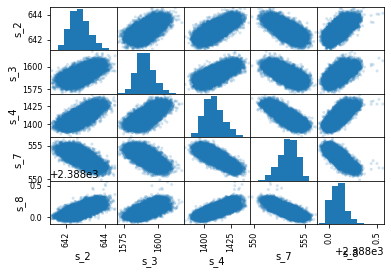

In [7]:
# the source tutorial drops some signals. Here are a few it keeps
good_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8']
pd.plotting.scatter_matrix(train.loc[:,good_sensors], alpha=0.2)
plt.show()

In [8]:
train = add_remaining_useful_life(train)
train[index_names+['RUL']]

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187
...,...,...,...
20626,100,196,4
20627,100,197,3
20628,100,198,2
20629,100,199,1


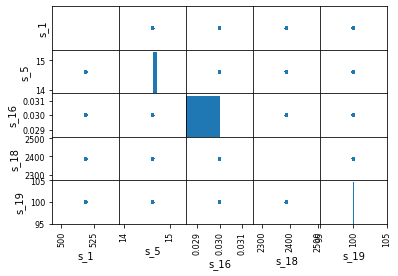

In [9]:
# these seem not worth keeping
import warnings
warnings.filterwarnings("ignore")
drop_sensors = ['s_1','s_5','s_16','s_18','s_19']
pd.plotting.scatter_matrix(train.loc[:,drop_sensors])
plt.show()

In [10]:
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

In [11]:
X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

In [12]:
X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

In [13]:
X_test

,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,642.58,1581.22,1398.91,21.61,554.42,2388.08,9056.40,1.3,47.23,521.79,2388.06,8130.11,8.4024,393,38.81,23.3552
1,642.55,1586.59,1410.83,21.61,553.52,2388.10,9044.77,1.3,47.67,521.74,2388.09,8126.90,8.4505,391,38.81,23.2618
2,642.88,1589.75,1418.89,21.61,552.59,2388.16,9049.26,1.3,47.88,520.83,2388.14,8131.46,8.4119,395,38.93,23.2740
3,642.78,1594.53,1406.88,21.61,552.64,2388.13,9051.30,1.3,47.65,521.88,2388.11,8133.64,8.4634,395,38.58,23.2581
4,642.27,1589.94,1419.36,21.61,553.29,2388.10,9053.99,1.3,47.46,521.00,2388.15,8125.74,8.4362,394,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,642.30,1590.88,1397.94,21.61,553.99,2388.03,9062.41,1.3,47.14,522.30,2388.01,8148.24,8.4110,391,38.96,23.4606
96,642.59,1582.96,1410.92,21.61,554.05,2388.06,9076.36,1.3,47.38,521.58,2388.06,8155.48,8.4500,395,38.61,23.2953
97,642.68,1599.51,1415.47,21.61,553.44,2388.13,9062.34,1.3,47.66,521.53,2388.09,8146.39,8.4235,394,38.76,23.3608
98,642.00,1585.03,1397.98,21.61,554.75,2388.01,9067.16,1.3,47.26,521.82,2388.02,8150.38,8.4003,391,38.95,23.3595


In [14]:
model = tf.keras.models.Sequential()

In [15]:
model.add(tf.keras.layers.Dense(units=500, activation='relu'))
# ann2.add(tf.keras.layers.Dense(units=250, activation='relu'))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=50, activation='relu'))
model.add(tf.keras.layers.Dense(units=1))

In [16]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [17]:
model.fit(X_train, y_train ,batch_size = 32, epochs = 10,verbose=2)

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

645/645 - 0s - loss: 7146.4424
Epoch 2/10
645/645 - 0s - loss: 5314.6113
Epoch 3/10
645/645 - 0s - loss: 5176.8242
Epoch 4/10
645/645 - 0s - loss: 5043.4946
Epoch 5/10
645/645 - 0s - loss: 4978.4897
Epoch 6/10
645/645 - 0s - loss: 4836.4697
Epoch 7/10
645/645 - 0s - loss: 4823.7129
Epoch 8/10
645/645 - 0s - loss: 4842.6035
Epoch 9/10
645/645 - 0s - loss: 4844.0166
Epoch 10/10
645/645 - 0s - loss: 4847.7842


In [18]:
model_pred = model.predict(X_test)

In [19]:
from sklearn.metrics import r2_score

In [20]:
r2_score(y_test,model_pred)

-0.3353723546752505

In [21]:
from sklearn.metrics import mean_squared_error
RMSE = np.sqrt(mean_squared_error(y_test,model_pred))
print("RMSE: ", RMSE)

RMSE:  48.02097379238688


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               8500      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 63,701
Trainable params: 63,701
Non-trainable params: 0
_________________________________________________________________
